In [1]:
from distributed import Executor, progress

In [2]:
e = Executor('dscheduler:8786')

In [3]:
e.restart()

<Executor: scheduler=dscheduler:8786 processes=3 cores=96>

In [5]:
import subprocess


def install_libs():
    libs = 'scikit-learn joblib pandas matplotlib'.split()
    return subprocess.check_call('conda install -yq'.split() + libs)

install_libs()

0

In [6]:
e.run(install_libs)

{'10.112.0.6:50032': 0, '10.112.1.3:47119': 0, '10.112.2.6:37968': 0}

In [8]:
n_cores = sum(e.ncores().values())
n_cores

96

In [9]:
from time import sleep
futures = e.map(sleep, [0.1] * (n_cores * 100), pure=False)
progress(futures)

In [15]:
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split

In [16]:
def load_cv_split(split_idx):
    data = load_digits()
    splitted = train_test_split(data.data, data.target,
                                test_size=0.20,
                                random_state=split_idx)
    return split_idx, splitted

In [19]:
cv_splits = e.scatter([load_cv_split(i) for i in range(3)],
                      broadcast=True)

In [20]:
cv_splits

[<Future: status: finished, key: 81c5b12b631fd1a707c92bba905da1bd>,
 <Future: status: finished, key: c4a211ca3ae298909c78bde726f3109b>,
 <Future: status: finished, key: c9787180397815b66c284d1b25f44589>]

In [21]:
from joblib import hash, Memory
from time import time


def evaluate_one(model_class, cv_split, parameters):
    split_idx, (X_train, X_val, y_train, y_val) = cv_split
    t0 = time()
    model = model_class(**parameters).fit(X_train, y_train)
    training_time = time() - t0

    train_score = model.score(X_train, y_train)
    validation_score = model.score(X_val, y_val)
    
    results = {
        'split_idx': split_idx,
        'training_time': training_time,
        'train_score': train_score,
        'validation_score': validation_score,
        'parameters_hash': hash(parameters),
        'parameters': parameters,
    }
    return results

In [22]:
import random

def launch_search(executor, model_class, param_space,
                  n_combinations=100, random_seed=None):
    rng = random.Random(random_seed)
    futures = []
    param_space = list(param_space)
    rng.shuffle(param_space)
    for params in param_space[:n_combinations]:
        for cv_split in cv_splits:
            f = executor.submit(evaluate_one, model_class,
                                cv_split, params)
            futures.append(f)
            
    return futures

In [38]:
from sklearn.grid_search import ParameterGrid
from sklearn.svm import SVC
import numpy as np
import pandas as pd


param_space = ParameterGrid({
    'C': np.logspace(-10, 10, 101),
    'gamma': np.logspace(-10, 10, 101),
    'tol': np.logspace(-4, -1, 4),
})

results = launch_search(e, SVC, param_space, n_combinations=n_cores * 10)

In [39]:
progress(results)

In [40]:
len([f for f in results if f.done()])

606

In [44]:
ready_list = e.gather([f for f in results if f.done()])
ready = pd.DataFrame.from_dict(ready_list)
ready.describe()

,split_idx,train_score,training_time,validation_score
count,2093.000000,2093.000000,2093.000000,2093.000000
mean,1.004300,0.570520,0.585984,0.266975
std,0.823577,0.442469,0.226018,0.357706
min,0.000000,0.105776,0.050811,0.077778
25%,0.000000,0.105776,0.584205,0.077778
50%,1.000000,0.956855,0.648043,0.080556
75%,2.000000,1.000000,0.714237,0.083333
max,2.000000,1.000000,1.242411,0.994444


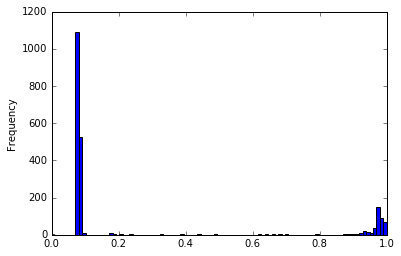

In [45]:
%matplotlib inline
ready['validation_score'].plot(kind='hist',
                               bins=np.linspace(0, 1, 100));

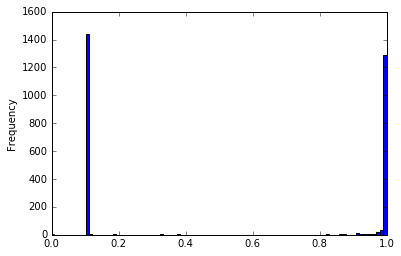

In [31]:
ready['train_score'].plot(kind='hist',
                          bins=np.linspace(0, 1, 100));

In [32]:
mean_evaluations = ready.groupby('parameters_hash').agg({
    'train_score': np.mean,
    'validation_score': np.mean,
    'training_time': np.mean,
}).reset_index()

all_parameters = pd.DataFrame.from_dict(list(ready['parameters']))
all_parameters['parameters_hash'] = ready['parameters_hash']

evaluations = (
    mean_evaluations
    .merge(all_parameters)
    .drop(['parameters_hash'], axis=1)
)

In [33]:
top10 = evaluations.sort_values(
    by='validation_score', ascending=False).head(10)
top10

,validation_score,train_score,training_time,C,gamma,tol
111,0.987963,1.000000,0.223611,6.309573e+09,0.001585,0.1000
2602,0.987963,1.000000,0.304209,6.309573e+00,0.001585,0.0001
1162,0.987963,1.000000,0.371959,1.000000e+04,0.001585,0.0010
113,0.987963,1.000000,0.223611,6.309573e+09,0.001585,0.1000
112,0.987963,1.000000,0.223611,6.309573e+09,0.001585,0.1000
805,0.987963,0.994201,0.139851,1.000000e+00,0.000398,0.0100
319,0.987963,1.000000,0.296609,1.000000e+06,0.001585,0.0010
320,0.987963,1.000000,0.296609,1.000000e+06,0.001585,0.0010
1935,0.987963,1.000000,0.226825,1.584893e+01,0.001585,0.1000
804,0.987963,0.994201,0.139851,1.000000e+00,0.000398,0.0100


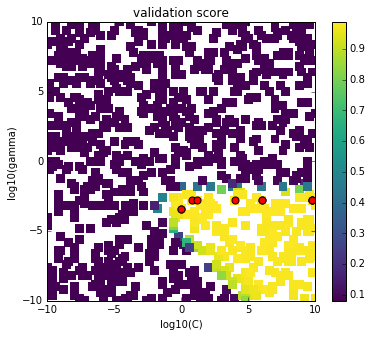

In [46]:
import matplotlib.pyplot as plt

def plot_param_map(df, target, title):
    plt.xlabel('log10(C)')
    plt.ylabel('log10(gamma)')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.scatter(np.log10(df['C']), np.log10(df['gamma']),
                c=target,
                marker='s', edgecolors='none',
                s=80, alpha=1, cmap='viridis')
    plt.colorbar()
    plt.title(title)

plt.figure(figsize=(6, 5))
plot_param_map(evaluations, evaluations['validation_score'],
               'validation score')
plt.scatter(np.log10(top10['C']), np.log10(top10['gamma']),
            c='r', s=50);

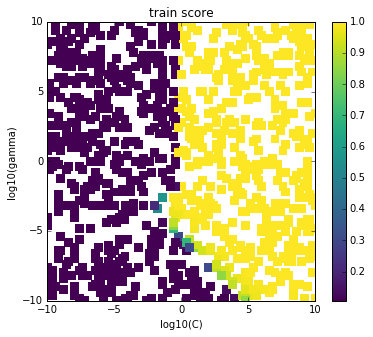

In [35]:
plt.figure(figsize=(6, 5))
plot_param_map(evaluations, evaluations['train_score'], 'train score')

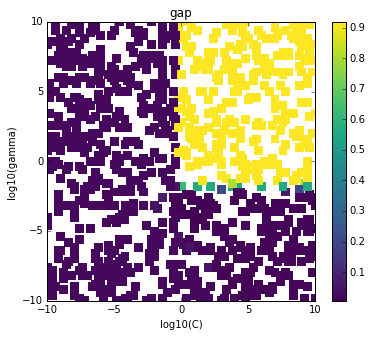

In [47]:
plt.figure(figsize=(6, 5))
gap = evaluations['train_score'] - evaluations['validation_score']
plot_param_map(evaluations, gap, 'gap')

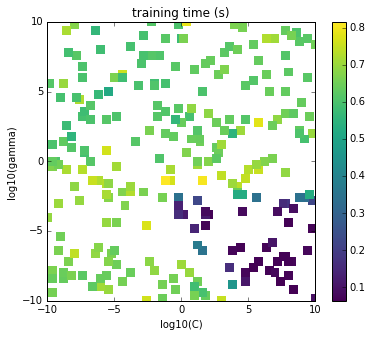

In [37]:
plt.figure(figsize=(6, 5))
high_tol = evaluations[evaluations['tol'] == 0.1]
plot_param_map(high_tol, high_tol['training_time'], 'training time (s)')